<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/3_AutoRegressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uni- vs. Multivariate Autoregressive Model

In [1]:
import pandas as pd

localurl = "./timeseries_data/normalized_data_multivariate_DOWNLOADED.csv"
dataframe = pd.read_csv(localurl,parse_dates=["datetime"])
dataframe.head(20)

,longitude,latitude,station_code,datetime,o3,no2,no,temp,press
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.566220,-337.675195
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.633418,-337.675195
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.646857,-337.675195
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.740934,-337.675195
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.767813,-337.675195
5,6.093923,50.754704,DENW094,1997-01-01 05:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.727494,-337.675195
6,6.093923,50.754704,DENW094,1999-07-05 15:00:00+00:00,1.706701,0.374967,0.409565,1.520635,-0.070334
7,6.093923,50.754704,DENW094,1999-07-05 15:00:00+00:00,1.771692,0.392283,0.409565,1.547514,-0.070334
8,6.093923,50.754704,DENW094,1999-07-05 16:00:00+00:00,1.836683,0.409430,0.409565,1.574393,-0.070334
9,6.093923,50.754704,DENW094,1999-07-05 16:00:00+00:00,1.846945,0.426413,0.409565,1.601272,-0.070334


In [2]:
dataframe.shape

(700846, 9)

## Updated Data Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Parameters for forecasting
context_window = 336  # 14 days of hourly data for context
prediction_horizon = 96  # 4 days ahead prediction

print("=== SARIMAX Time Series Forecasting ===")
print(f"Context window: {context_window} hours (14 days)")
print(f"Prediction horizon: {prediction_horizon} hours (4 days)")

# Prepare data for DENW094 station
station_data = dataframe[dataframe['station_code'] == 'DENW094'].copy()
station_data = station_data.sort_values('datetime').reset_index(drop=True)

print(f"\nStation DENW094 data shape: {station_data.shape}")
print(f"Date range: {station_data['datetime'].min()} to {station_data['datetime'].max()}")

# Find a good continuous section for analysis
# Let's find sections with minimal gaps
station_data['time_diff'] = station_data['datetime'].diff()
hourly_gaps = station_data['time_diff'] == pd.Timedelta(hours=1)

print(f"Percentage of 1-hour gaps: {hourly_gaps.mean()*100:.1f}%")

# Find a suitable starting point with good data quality
# Let's look for a section in the middle of the dataset with good continuity
mid_point = len(station_data) // 2
search_start = max(0, mid_point - 5000)
search_end = min(len(station_data), mid_point + 5000)

best_start = search_start
max_continuous = 0

# Find the longest continuous stretch in the search area
for start_idx in range(search_start, search_end - (context_window + prediction_horizon)):
    end_idx = start_idx + context_window + prediction_horizon
    section = station_data.iloc[start_idx:end_idx]
    
    if len(section) == context_window + prediction_horizon:
        time_span = (section['datetime'].iloc[-1] - section['datetime'].iloc[0]).total_seconds() / 3600
        expected_span = context_window + prediction_horizon - 1
        
        # Allow some flexibility but prefer closer to ideal
        if time_span <= expected_span * 1.2:  # Allow 20% extra time for some gaps
            continuous_score = expected_span / time_span  # Higher is better
            if continuous_score > max_continuous:
                max_continuous = continuous_score
                best_start = start_idx

print(f"Selected data starting at index {best_start}")
print(f"Continuity score: {max_continuous:.3f} (1.0 = perfect)")

# Extract the selected section
selected_data = station_data.iloc[best_start:best_start + context_window + prediction_horizon].copy()
print(f"Selected section: {selected_data['datetime'].iloc[0]} to {selected_data['datetime'].iloc[-1]}")

# Split into context and prediction periods
context_data = selected_data.iloc[:context_window]
future_data = selected_data.iloc[context_window:]

print(f"Context period: {context_data['datetime'].iloc[0]} to {context_data['datetime'].iloc[-1]}")
print(f"Prediction period: {future_data['datetime'].iloc[0]} to {future_data['datetime'].iloc[-1]}")

# Prepare series for modeling
o3_series = context_data['o3'].values
actual_future = future_data['o3'].values

# For multivariate model, prepare exogenous variables
exog_context = context_data[['temp']].values # 'o3', 'no2', 'no', 'press'
exog_future = future_data[['temp']].values # 'o3', 'no2', 'no', 'press'

print(f"\nO3 series length: {len(o3_series)}")
print(f"Actual future length: {len(actual_future)}")
print(f"Exogenous variables shape: {exog_context.shape}")

=== SARIMAX Time Series Forecasting ===
Context window: 336 hours (14 days)
Prediction horizon: 96 hours (4 days)

Station DENW094 data shape: (700846, 9)
Date range: 1997-01-01 00:00:00+00:00 to 2024-01-01 01:00:00+00:00
Percentage of 1-hour gaps: 21.0%
Selected data starting at index 350775
Continuity score: 4.954 (1.0 = perfect)
Selected section: 2015-06-19 05:00:00+00:00 to 2015-06-22 20:00:00+00:00
Context period: 2015-06-19 05:00:00+00:00 to 2015-06-22 01:00:00+00:00
Prediction period: 2015-06-22 01:00:00+00:00 to 2015-06-22 20:00:00+00:00

O3 series length: 336
Actual future length: 96
Exogenous variables shape: (336, 1)


### Forecasting Both Variants


=== Univariate SARIMAX (O3 only) ===
ADF p-value for O3: 0.022020
Using differencing parameter d = 0
Fitting univariate SARIMAX model...
Univariate SARIMAX - MSE: 0.1103, RMSE: 0.3322
AIC: -659.60

=== Multivariate SARIMAX (O3 + Temperature + Other variables) ===
Multivariate SARIMAX - MSE: 0.1056, RMSE: 0.3250
AIC: -727.05

=== Plotting Results ===


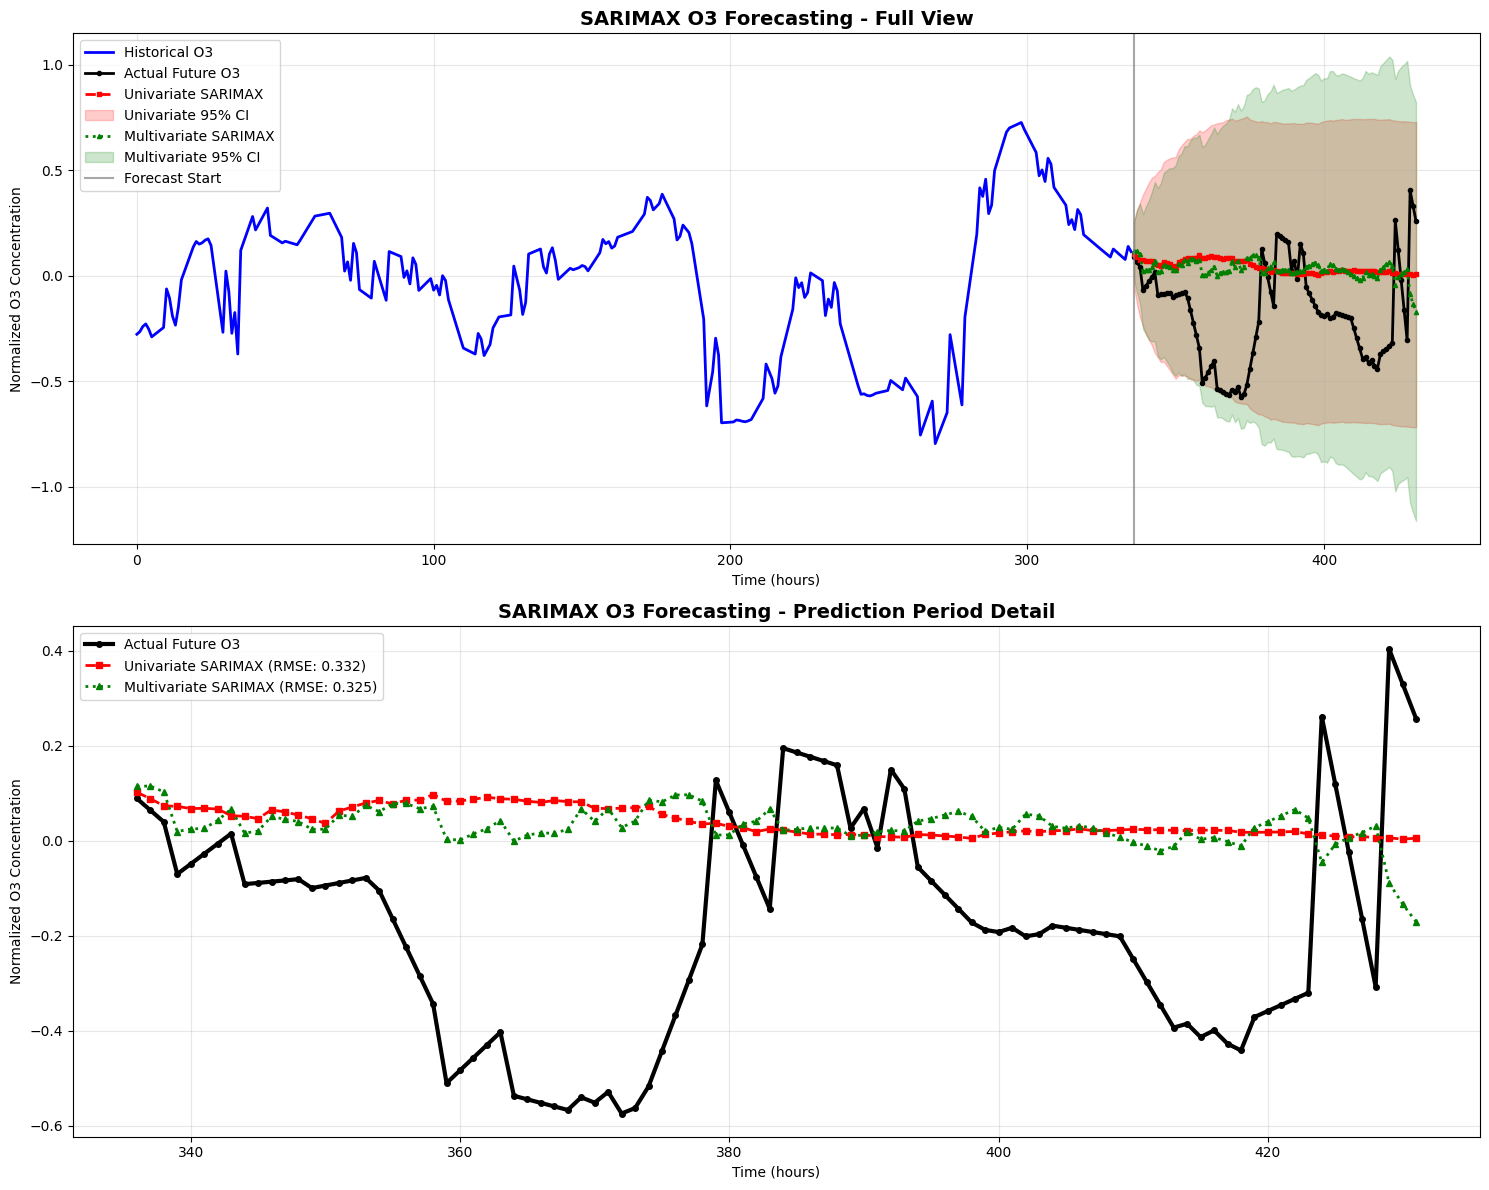


=== Model Comparison Summary ===
               Model                 Variables    MSE   RMSE     AIC
  Univariate SARIMAX                   O3 only 0.1103 0.3322 -659.60
Multivariate SARIMAX O3 + Temperature + Others 0.1056 0.3250 -727.05

Multivariate model RMSE improvement: 2.17%


In [4]:
# === UNIVARIATE SARIMAX MODEL ===
print("\n=== Univariate SARIMAX (O3 only) ===")

# Check stationarity
adf_test = adfuller(o3_series)
p_value = adf_test[1]
print(f"ADF p-value for O3: {p_value:.6f}")

# Determine differencing
d = 0 if p_value < 0.05 else 1
seasonal_period = 24  # Daily seasonality for hourly data

print(f"Using differencing parameter d = {d}")
print("Fitting univariate SARIMAX model...")

try:
    # Fit univariate SARIMAX model for O3
    univariate_model = SARIMAX(
        o3_series,
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecast
    univariate_forecast = univariate_model.get_forecast(steps=prediction_horizon)
    univariate_pred = univariate_forecast.predicted_mean
    univariate_ci = univariate_forecast.conf_int()
    
    # Calculate metrics
    univariate_mse = mean_squared_error(actual_future, univariate_pred)
    univariate_rmse = np.sqrt(univariate_mse)
    
    print(f"Univariate SARIMAX - MSE: {univariate_mse:.4f}, RMSE: {univariate_rmse:.4f}")
    print(f"AIC: {univariate_model.aic:.2f}")
    
    univariate_success = True
    
except Exception as e:
    print(f"Univariate model failed: {e}")
    univariate_success = False

# === MULTIVARIATE SARIMAX MODEL ===
print("\n=== Multivariate SARIMAX (O3 + Temperature + Other variables) ===")

try:
    # Fit multivariate SARIMAX model with exogenous variables
    multivariate_model = SARIMAX(
        o3_series,  # O3 is now the target
        exog=exog_context,  # Temperature, NO2, NO, Pressure as exogenous
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecast with exogenous variables
    multivariate_forecast = multivariate_model.get_forecast(
        steps=prediction_horizon, 
        exog=exog_future
    )
    multivariate_pred = multivariate_forecast.predicted_mean
    multivariate_ci = multivariate_forecast.conf_int()
    
    # Calculate metrics
    multivariate_mse = mean_squared_error(actual_future, multivariate_pred)
    multivariate_rmse = np.sqrt(multivariate_mse)
    
    print(f"Multivariate SARIMAX - MSE: {multivariate_mse:.4f}, RMSE: {multivariate_rmse:.4f}")
    print(f"AIC: {multivariate_model.aic:.2f}")
    
    multivariate_success = True
    
except Exception as e:
    print(f"Multivariate model failed: {e}")
    multivariate_success = False

# === PLOTTING RESULTS ===
print("\n=== Plotting Results ===")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Time indices for plotting
context_time = np.arange(context_window)
future_time = np.arange(context_window, context_window + prediction_horizon)

# Plot 1: Full comparison
ax1.plot(context_time, o3_series, label="Historical O3", color="blue", linewidth=2)
ax1.plot(future_time, actual_future, label="Actual Future O3", color="black", linewidth=2, marker='o', markersize=3)

if univariate_success:
    ax1.plot(future_time, univariate_pred, label="Univariate SARIMAX", 
             color="red", linestyle="--", linewidth=2, marker='s', markersize=3)
    # Handle confidence intervals - they might be DataFrame or array
    if hasattr(univariate_ci, 'iloc'):
        ax1.fill_between(future_time, univariate_ci.iloc[:, 0], univariate_ci.iloc[:, 1], 
                         color="red", alpha=0.2, label="Univariate 95% CI")
    else:
        ax1.fill_between(future_time, univariate_ci[:, 0], univariate_ci[:, 1], 
                         color="red", alpha=0.2, label="Univariate 95% CI")

if multivariate_success:
    ax1.plot(future_time, multivariate_pred, label="Multivariate SARIMAX", 
             color="green", linestyle=":", linewidth=2, marker='^', markersize=3)
    # Handle confidence intervals - they might be DataFrame or array
    if hasattr(multivariate_ci, 'iloc'):
        ax1.fill_between(future_time, multivariate_ci.iloc[:, 0], multivariate_ci.iloc[:, 1], 
                         color="green", alpha=0.2, label="Multivariate 95% CI")
    else:
        ax1.fill_between(future_time, multivariate_ci[:, 0], multivariate_ci[:, 1], 
                         color="green", alpha=0.2, label="Multivariate 95% CI")

ax1.axvline(x=context_window, color='gray', linestyle='-', alpha=0.7, label="Forecast Start")
ax1.set_title("SARIMAX O3 Forecasting - Full View", fontsize=14, fontweight='bold')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Normalized O3 Concentration")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Zoomed in on prediction period
ax2.plot(future_time, actual_future, label="Actual Future O3", color="black", linewidth=3, marker='o', markersize=4)

if univariate_success:
    ax2.plot(future_time, univariate_pred, label=f"Univariate SARIMAX (RMSE: {univariate_rmse:.3f})", 
             color="red", linestyle="--", linewidth=2, marker='s', markersize=4)

if multivariate_success:
    ax2.plot(future_time, multivariate_pred, label=f"Multivariate SARIMAX (RMSE: {multivariate_rmse:.3f})", 
             color="green", linestyle=":", linewidth=2, marker='^', markersize=4)

ax2.set_title("SARIMAX O3 Forecasting - Prediction Period Detail", fontsize=14, fontweight='bold')
ax2.set_xlabel("Time (hours)")
ax2.set_ylabel("Normalized O3 Concentration")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === SUMMARY TABLE ===
print("\n=== Model Comparison Summary ===")
results_summary = []

if univariate_success:
    results_summary.append({
        'Model': 'Univariate SARIMAX',
        'Variables': 'O3 only',
        'MSE': f"{univariate_mse:.4f}",
        'RMSE': f"{univariate_rmse:.4f}",
        'AIC': f"{univariate_model.aic:.2f}"
    })

if multivariate_success:
    results_summary.append({
        'Model': 'Multivariate SARIMAX', 
        'Variables': 'O3 + Temperature + Others',
        'MSE': f"{multivariate_mse:.4f}",
        'RMSE': f"{multivariate_rmse:.4f}",
        'AIC': f"{multivariate_model.aic:.2f}"
    })

if results_summary:
    summary_df = pd.DataFrame(results_summary)
    print(summary_df.to_string(index=False))
    
    if univariate_success and multivariate_success:
        improvement = ((univariate_rmse - multivariate_rmse) / univariate_rmse) * 100
        print(f"\nMultivariate model RMSE improvement: {improvement:.2f}%")
else:
    print("No models succeeded - check data quality and parameters")



=== TRYING IMPROVED O3 MODELS ===

Trying Simple AR(3)...
  RMSE: 0.3173, AIC: -708.49
  Prediction std: 0.0288, range: [0.0052, 0.1106]

Trying AR(2) + MA(1)...
  RMSE: 0.2768, AIC: -715.93
  Prediction std: 0.0361, range: [-0.0640, 0.1017]

Trying Seasonal AR(2)...
  RMSE: 0.3200, AIC: -647.50
  Prediction std: 0.0293, range: [0.0068, 0.1105]

Trying Complex ARIMA...


/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 0.3512, AIC: -644.54
  Prediction std: 0.0557, range: [-0.0213, 0.1904]

=== BEST MODEL: AR(2) + MA(1) ===
RMSE: 0.2768
AIC: -715.93
Prediction std: 0.0361


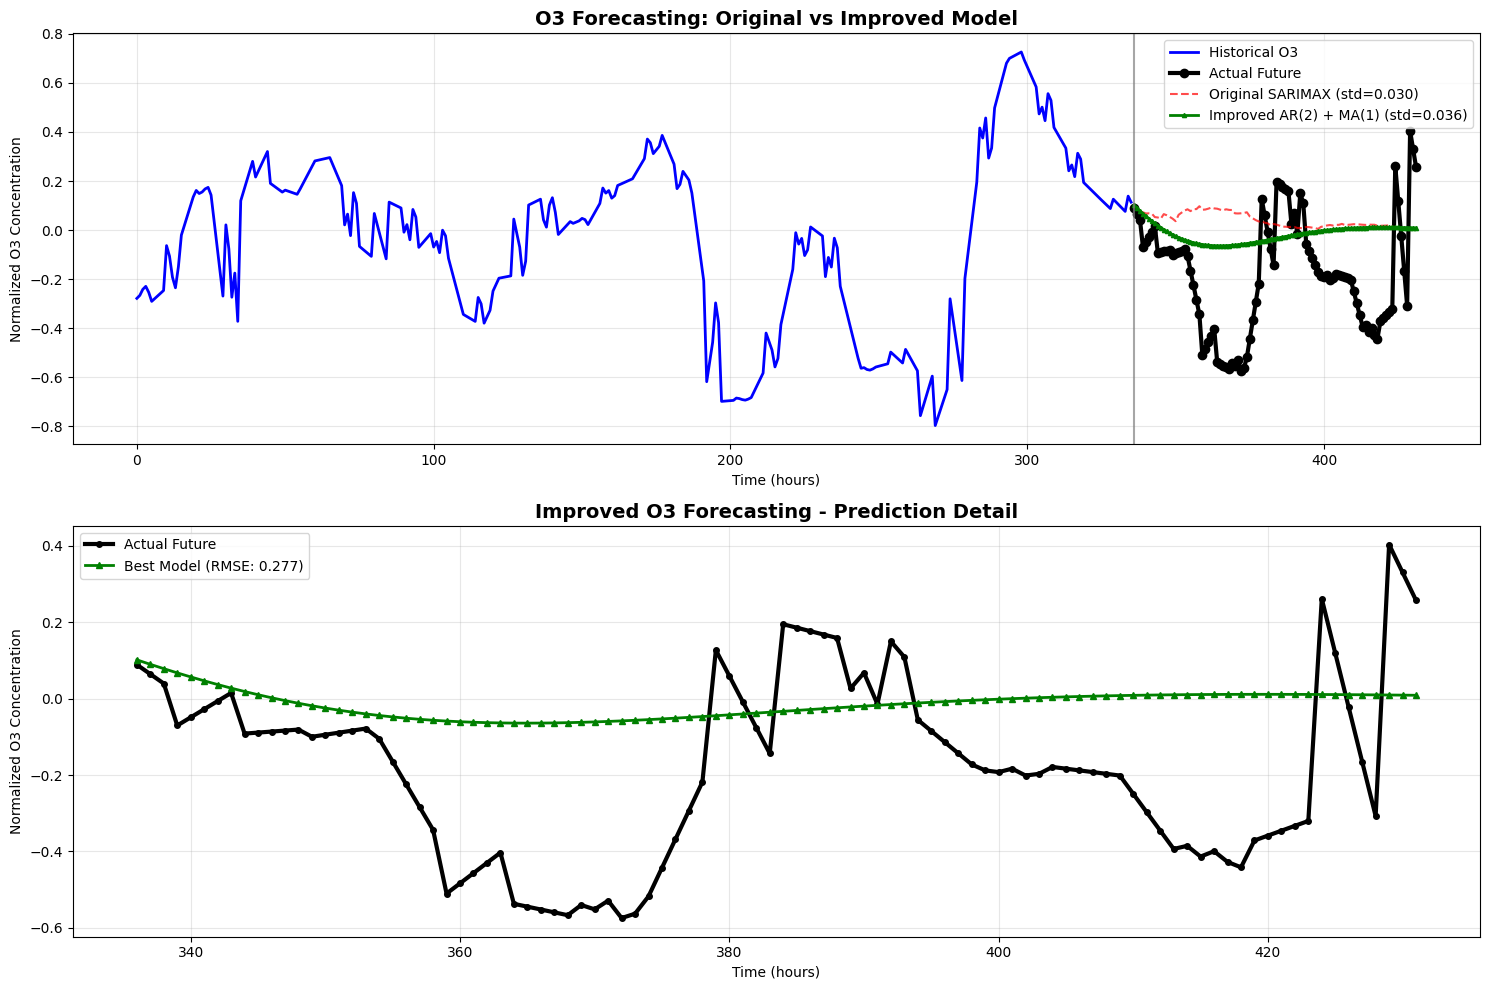

In [5]:
# === IMPROVED O3 MODELS WITH BETTER PARAMETERS ===
print("\n=== TRYING IMPROVED O3 MODELS ===")

# Try different model configurations for O3
model_configs = [
    {"name": "Simple AR(3)", "order": (3, 0, 0), "seasonal": (0, 0, 0, 0)},
    {"name": "AR(2) + MA(1)", "order": (2, 0, 1), "seasonal": (0, 0, 0, 0)},
    {"name": "Seasonal AR(2)", "order": (2, 0, 0), "seasonal": (1, 0, 0, 24)},
    {"name": "Complex ARIMA", "order": (3, 0, 2), "seasonal": (1, 0, 1, 24)},
]

best_model = None
best_rmse = float('inf')
best_config = None
best_pred = None

for config in model_configs:
    try:
        print(f"\nTrying {config['name']}...")
        
        # Univariate model
        model = SARIMAX(
            o3_series,
            order=config['order'],
            seasonal_order=config['seasonal'],
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        # Forecast
        forecast = model.get_forecast(steps=prediction_horizon)
        pred = forecast.predicted_mean
        
        # Calculate metrics
        mse = mean_squared_error(actual_future, pred)
        rmse = np.sqrt(mse)
        
        print(f"  RMSE: {rmse:.4f}, AIC: {model.aic:.2f}")
        print(f"  Prediction std: {pred.std():.4f}, range: [{pred.min():.4f}, {pred.max():.4f}]")
        
        # Check if this is the best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_config = config
            best_pred = pred
            
    except Exception as e:
        print(f"  Failed: {e}")

if best_model is not None:
    print(f"\n=== BEST MODEL: {best_config['name']} ===")
    print(f"RMSE: {best_rmse:.4f}")
    print(f"AIC: {best_model.aic:.2f}")
    print(f"Prediction std: {best_pred.std():.4f}")
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Original vs Improved
    ax1.plot(context_time, o3_series, label="Historical O3", color="blue", linewidth=2)
    ax1.plot(future_time, actual_future, label="Actual Future", color="black", linewidth=3, marker='o')
    
    if univariate_success:
        ax1.plot(future_time, univariate_pred, label=f"Original SARIMAX (std={univariate_pred.std():.3f})", 
                 color="red", linestyle="--", alpha=0.7)
    
    ax1.plot(future_time, best_pred, label=f"Improved {best_config['name']} (std={best_pred.std():.3f})", 
             color="green", linewidth=2, marker='^', markersize=3)
    
    ax1.axvline(x=context_window, color='gray', linestyle='-', alpha=0.7)
    ax1.set_title("O3 Forecasting: Original vs Improved Model", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time (hours)")
    ax1.set_ylabel("Normalized O3 Concentration")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Zoomed prediction period
    ax2.plot(future_time, actual_future, label="Actual Future", color="black", linewidth=3, marker='o', markersize=4)
    ax2.plot(future_time, best_pred, label=f"Best Model (RMSE: {best_rmse:.3f})", 
             color="green", linewidth=2, marker='^', markersize=4)
    
    ax2.set_title("Improved O3 Forecasting - Prediction Detail", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("Normalized O3 Concentration")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No improved models succeeded")